<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Создание-признаков" data-toc-modified-id="Создание-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Создание признаков</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Сервис заказа такси собрал исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

План выполнения проекта:

1. Загрузить данные.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [3]:
from prophet import Prophet

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/taxi.csv', index_col=[0], parse_dates=[0]) 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
df.index.is_monotonic

True

У нас есть данные за 6 мес. с марта 2018 по август 2018. Интервал - 10 минут. Данные расположены в хронологическом порядке.

Необходимо предсказать количество заказов на следующий час, поэтому выполним ресемплирование по 1 часу.

In [8]:
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [9]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Сохраню оригинальный датасет без изменений для возможности экспериментов

In [10]:
df_orig=df.copy()

## Анализ

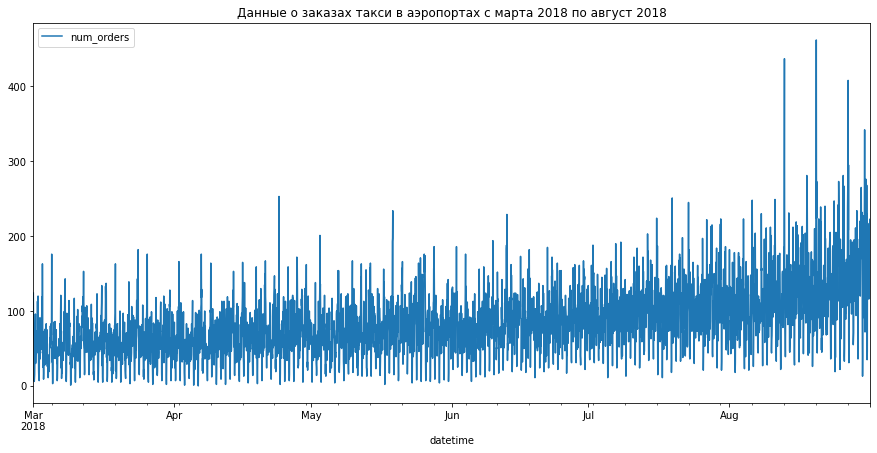

In [11]:
df.plot(figsize=(15,7))
plt.title('Данные о заказах такси в аэропортах с марта 2018 по август 2018');

Text(0.5, 1.0, 'Данные о заказах такси в аэропортах с марта 2018 по август 2018 с обозначением стандартного среднего')

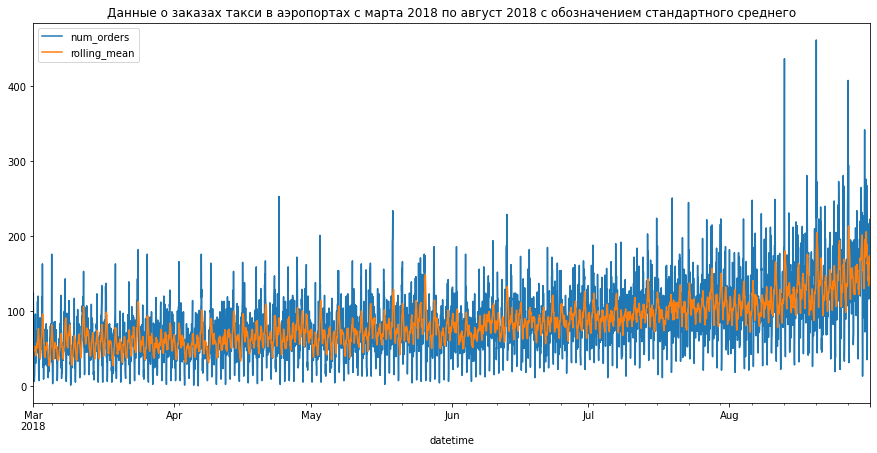

In [12]:
df['rolling_mean'] = df.rolling(10).mean() 

df.plot(figsize=(15,7))
plt.title('Данные о заказах такси в аэропортах с марта 2018 по август 2018 с обозначением стандартного среднего')

In [13]:
df = df.drop(['rolling_mean'], axis=1)

In [14]:
decomposed = seasonal_decompose(df)

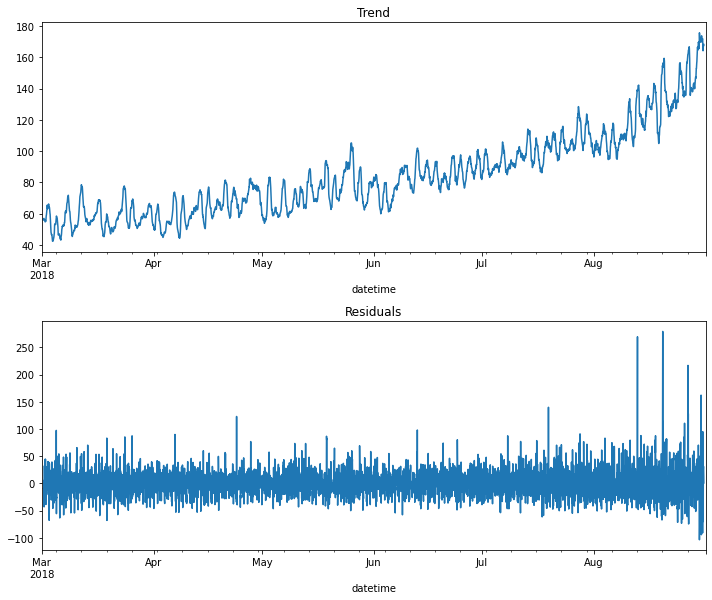

In [15]:
plt.figure(figsize=(10, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

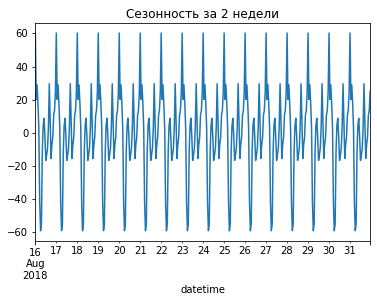

In [16]:
decomposed.seasonal['2018-08-16':'2018-08-31'].plot(ax=plt.gca())
plt.title('Сезонность за 2 недели');

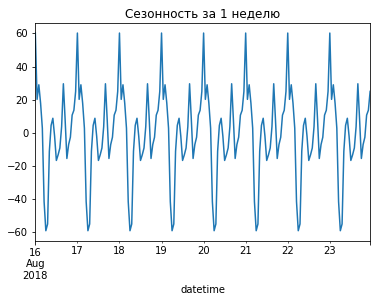

In [17]:
decomposed.seasonal['2018-08-16':'2018-08-23'].plot(ax=plt.gca())
plt.title('Сезонность за 1 неделю');

Видно, что в целом идет увеличение числа заказов - это может быть связано с тем, что летом люди чаще летают в отпуск, а может быть и в целом с увеличеием популярности приложения. Сезонности нет - опять же небольшой промежуток времени, но интересно, что нет изменения спроса по выходным, например

### Создание признаков

Данные представлены за 6 месяцев, поэтому нет смысла добавлять в функцию параметры года и месяца. Оставлять парметр часа в неизменном виде кажется мне неправильным - разница между, например, 23 часами понедельника и 1 часом вторника будет слишком большой. Чтобы избежать этого, добавлю параметры синуса и косинуса часа. 

In [18]:
def make_features(df, max_lag, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['hour']=df.index.hour
    df['sin_hour'] = np.sin(2*np.pi*df['hour']/24)
    df['cos_hour'] = np.cos(2*np.pi*df['hour']/24)
    df.drop(['hour'], axis=1)
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean']=df['num_orders'].shift().rolling(rolling_mean_size).mean()

## Обучение

### Линейная регрессия

In [19]:
%%time
best_i=0
best_j=0
best_rmse_lin=48

for i in range(1,50,3):
    df = df_orig.copy()
    for j in range(1,50,3):
        df = df_orig.copy()
        make_features(df, i, j)
        train, valid_test = train_test_split(df, shuffle=False, test_size=0.2)
        valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
        train = train.dropna()
        valid = valid.dropna()
        target_train = train['num_orders']
        features_train = train.drop(['num_orders'], axis=1)
        target_valid = valid['num_orders']
        features_valid = valid.drop(['num_orders'], axis=1)

        
        model = LinearRegression()
        model.fit(features_train, target_train) 

        predictions = model.predict(features_valid) 
        result=mean_squared_error(target_valid, predictions)**0.5
        
        if result<best_rmse_lin:
            best_rmse_lin=result
            best_i=i
            best_j=j

print(best_i, best_j, best_rmse_lin)

49 1 31.537407949249808
CPU times: total: 37.4 s
Wall time: 9.79 s


### CatBoost

In [20]:
%%time
best_i=0
best_j=0
best_rmse_cat=48

for i in range(1,50,3):
    df = df_orig.copy()
    for j in range(1,50,3):
        df = df_orig.copy()
        make_features(df, i, j)
        train, valid_test = train_test_split(df, shuffle=False, test_size=0.2)
        valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
        train = train.dropna()
        valid = valid.dropna()
        target_train = train['num_orders']
        features_train = train.drop(['num_orders'], axis=1)
        target_valid = valid['num_orders']
        features_valid = valid.drop(['num_orders'], axis=1)

        
        model = CatBoostRegressor(iterations = 10, verbose=11, loss_function='RMSE')
        model.fit(features_train, target_train) 

        predictions = model.predict(features_valid) 
        result=mean_squared_error(target_valid, predictions)**0.5
        
        if result<best_rmse_cat:
            best_rmse_cat=result
            best_i=i
            best_j=j

print(best_i, best_j, best_rmse_cat)

Learning rate set to 0.5
0:	learn: 29.0711140	total: 126ms	remaining: 1.14s
9:	learn: 23.6644962	total: 145ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 29.1158317	total: 2.43ms	remaining: 21.9ms
9:	learn: 22.2847575	total: 21.8ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.4616409	total: 2.29ms	remaining: 20.6ms
9:	learn: 21.4056540	total: 22.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.3805290	total: 2.55ms	remaining: 23ms
9:	learn: 21.1556143	total: 22.4ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.0518569	total: 2.59ms	remaining: 23.3ms
9:	learn: 21.0145187	total: 22.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.9639865	total: 2.42ms	remaining: 21.8ms
9:	learn: 21.3543569	total: 21.5ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 28.0217441	total: 2.57ms	remaining: 23.2ms
9:	learn: 21.2397021	total: 22.1ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 27.9661444	total: 2.32ms	remaining: 20.9ms
9:	learn: 21.0821220	total: 21.

### Prophet

In [21]:
df_prop = df_orig.reset_index()
df_prop.columns = ['ds', 'y']
train, valid_test = train_test_split(df_prop, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

In [22]:
valid.head()

,ds,y
3532,2018-07-26 04:00:00,131
3533,2018-07-26 05:00:00,83
3534,2018-07-26 06:00:00,21
3535,2018-07-26 07:00:00,39
3536,2018-07-26 08:00:00,80


In [23]:
valid.tail()

,ds,y
3969,2018-08-13 09:00:00,137
3970,2018-08-13 10:00:00,156
3971,2018-08-13 11:00:00,144
3972,2018-08-13 12:00:00,92
3973,2018-08-13 13:00:00,119


In [24]:
%%time
m = Prophet()
m.fit(train)

15:33:45 - cmdstanpy - INFO - Chain [1] start processing
15:33:46 - cmdstanpy - INFO - Chain [1] done processing


CPU times: total: 953 ms
Wall time: 1.9 s


In [25]:
%%time
future = m.make_future_dataframe(periods=len(valid), freq='H')
forecast = m.predict(future)
future.tail()

CPU times: total: 1.41 s
Wall time: 896 ms


,ds
3969,2018-08-13 09:00:00
3970,2018-08-13 10:00:00
3971,2018-08-13 11:00:00
3972,2018-08-13 12:00:00
3973,2018-08-13 13:00:00


CPU times: total: 1.03 s
Wall time: 1.03 s


Text(0.5, 1.0, 'Временной ряд спрогнозированный Prophet')

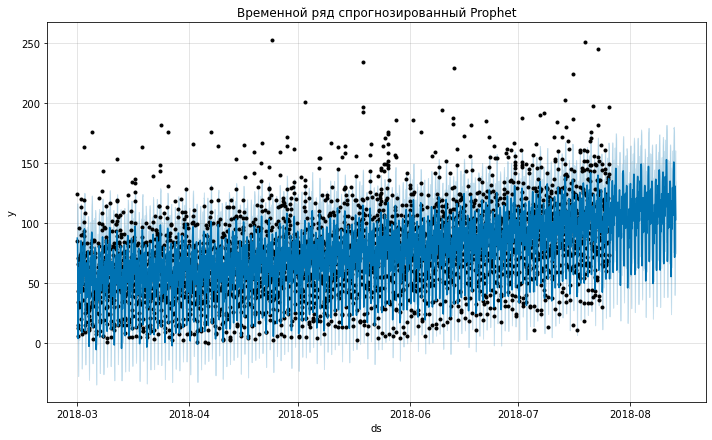

In [26]:
%%time
m.plot(forecast)
plt.title('Временной ряд спрогнозированный Prophet');

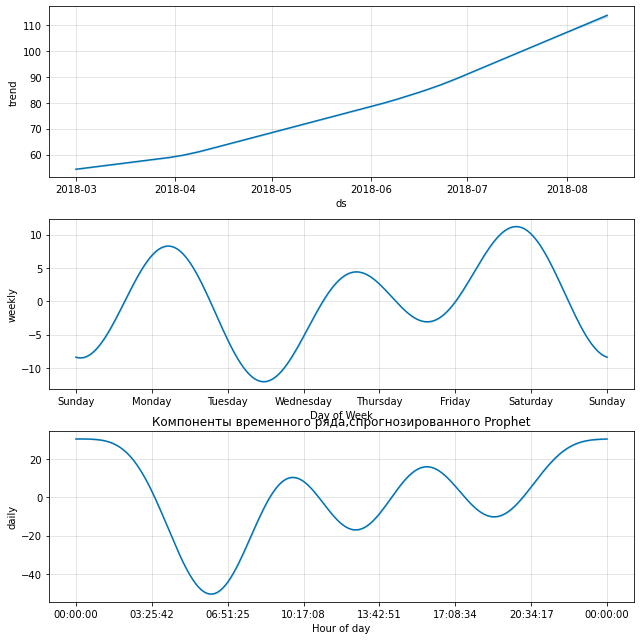

In [27]:
m.plot_components(forecast)
plt.title('Компоненты временного ряда,спрогнозированного Prophet');

In [28]:
%%time
df_proph = df_prop[:3974]
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_proph.set_index('ds'))
cmp_df.head()

CPU times: total: 0 ns
Wall time: 940 µs


,yhat,yhat_lower,yhat_upper,y
ds,,,,
2018-03-01 00:00:00,87.339436,56.060097,116.437957,124
2018-03-01 01:00:00,86.529444,57.329535,116.435055,85
2018-03-01 02:00:00,82.007265,48.810167,110.952097,71
2018-03-01 03:00:00,68.018968,37.639852,96.499502,66
2018-03-01 04:00:00,43.374439,13.964582,72.519575,43


In [29]:
%%time
cmp_df = cmp_df['2018-07-26 04:00:00':]
result_prop = mean_squared_error(cmp_df['y'], cmp_df['yhat'])**0.5
result_prop

CPU times: total: 0 ns
Wall time: 0 ns


33.72893958511752

In [30]:
data = pd.DataFrame(
    {'model': ['LinearRegression', 'CatBoostRegressor', 'Prophet'], 
     'prediction_time':[9.76, 96, 5.34],
     'RMSE':[best_rmse_lin, best_rmse_cat, result_prop]
    }
)
data

,model,prediction_time,RMSE
0,LinearRegression,9.76,31.537408
1,CatBoostRegressor,96.00,31.853387
2,Prophet,5.34,33.728940


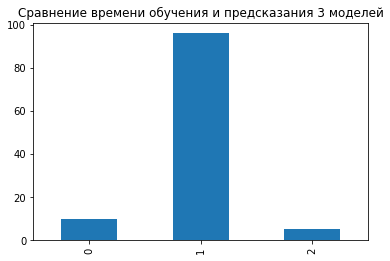

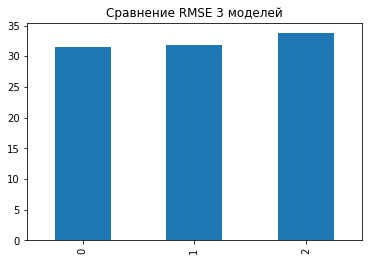

In [31]:
data['prediction_time'].plot(kind='bar')
plt.title('Сравнение времени обучения и предсказания 3 моделей');
plt.show()
data['RMSE'].plot(kind='bar')
plt.title('Сравнение RMSE 3 моделей');
plt.show()

На мой взгляд, лучшая модель -логистическая регрессия. RMSE 31.53, обучается и предсказывает за 10 секунд. 

Из плюсов Prophet - нет необходимости в подготовке данных, быстрое выполнение кода. Но RMSE на валидационных данных 33,73 - выше, чем у остальных моделей.

Итоговой моделью оставлю Линейную регрессию

## Тестирование

In [33]:
df = df_orig.copy()
make_features(df, 49,1)
train, valid_test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)

train = train.dropna()
valid = valid.dropna()

target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis=1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis=1)
        
model = LinearRegression()
model.fit(features_train, target_train) 

predictions = model.predict(features_test) 
result=mean_squared_error(target_test, predictions)**0.5

print(result)

41.79941207453191


## Вывод

Задача была спрогнозировать количество заказов такси в аэропорту в ближайший час на основании данных о заказах за последние 6 месяцев. В результате анализа получены следующие результаты: в целом идет увеличение числа заказов - это может быть связано с тем, что летом люди чаще летают в отпуск, а может быть и в целом с увеличеием популярности приложения. Сезонности нет - опять же небольшой промежуток времени, но интересно, что нет изменения спроса по выходным, например.

Построены 3 модели - Линейная регрессия, градиентный бустинг и Prophet. Для оценки качества использовалась метрика RMSE. На валидационной выборке лучше всего себя показала Линейная регрессия, поэтому эта модель выбрана для тестирования. На тестовых данных результат RMSE = 41,8.